In [1]:
import pandas as pd

df = pd.read_pickle('../data/final_preprocessed_dataset.pkl')


In [2]:
print(df.columns.tolist())


['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'Chronological_Age', 'BMI', 'Pulse_Pressure', 'MAP', 'SBP_DBP_Ratio', 'Obesity_Class', 'Lifestyle_Risk', 'height_scaled', 'weight_scaled', 'ap_hi_scaled', 'ap_lo_scaled', 'BMI_scaled', 'MAP_scaled', 'Pulse_Pressure_scaled', 'SBP_DBP_Ratio_scaled', 'Obesity_Class_Encoded']


In [3]:
from sklearn.preprocessing import StandardScaler

# Features to scale
features_to_scale = ['height', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'MAP', 'Pulse_Pressure', 'SBP_DBP_Ratio']

# Scale and add new columns
scaler = StandardScaler()
scaled = scaler.fit_transform(df[features_to_scale])

for i, col in enumerate(features_to_scale):
    df[f"{col}_scaled"] = scaled[:, i]


In [4]:
df['HighChol_Flag'] = (df['cholesterol'] > 1).astype(int)
df['HighGluc_Flag'] = (df['gluc'] > 1).astype(int)


In [5]:
df['Obesity_Class_Encoded'] = df['Obesity_Class'].astype('category').cat.codes


In [6]:
# Target
y = df['Chronological_Age']

# Features to use
scaled_features = ['height_scaled', 'weight_scaled', 'ap_hi_scaled', 'ap_lo_scaled', 
                   'BMI_scaled', 'MAP_scaled', 'Pulse_Pressure_scaled', 'SBP_DBP_Ratio_scaled']

binary_features = ['gender', 'smoke', 'alco', 'active', 'cardio', 'HighChol_Flag', 'HighGluc_Flag', 'Lifestyle_Risk']
categorical_encoded = ['Obesity_Class_Encoded']

X = df[scaled_features + binary_features + categorical_encoded]


In [7]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [35]:
%pip install xgboost lightgbm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Dictionary of all models
all_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate all models
all_results = []

for name, model in all_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    all_results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    })

# Create final comparison table
comparison_df = pd.DataFrame(all_results).set_index('Model').sort_values('RMSE')
print("📊 Full Model Comparison:\n")
print(comparison_df.round(4))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254
📊 Full Model Comparison:

                      MAE    RMSE      R²
Model                                    
LightGBM           5.3297  6.4353  0.1075
Linear Regression  5.4062  6.5079  0.0872
Ridge Regression   5.4062  6.5079  0.0872
Lasso Regression   5.4073  6.5084  0.0871
XGBoost            5.3789  6.5097  0.0867
AdaBoost           5.5820  6.6365  0.0508
Random Forest      5.7081  6.9744 -0.0483


In [10]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# 1. Define custom scorers
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# 2. Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Define all models
all_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# 4. Evaluate each model
cv_results = []

for name, model in all_models.items():
    mae = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
    rmse = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    r2 = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer)

    cv_results.append({
        'Model': name,
        'MAE (mean ± std)': f"{abs(mae.mean()):.4f} ± {mae.std():.4f}",
        'RMSE (mean ± std)': f"{abs(rmse.mean()):.4f} ± {rmse.std():.4f}",
        'R² (mean ± std)': f"{r2.mean():.4f} ± {r2.std():.4f}"
    })

# 5. Create final results table
cv_df = pd.DataFrame(cv_results).set_index('Model')
print("📊 5-Fold Cross-Validation Comparison for All Models:")
display(cv_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 54977, number of used features: 17
[LightGBM] [Info] Start training from score 52.778889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

,MAE (mean ± std),RMSE (mean ± std),R² (mean ± std)
Model,,,
Linear Regression,5.3624 ± 0.0302,6.4682 ± 0.0260,0.0855 ± 0.0028
Ridge Regression,5.3624 ± 0.0302,6.4682 ± 0.0260,0.0855 ± 0.0028
Lasso Regression,5.3640 ± 0.0297,6.4689 ± 0.0259,0.0853 ± 0.0030
Random Forest,5.6574 ± 0.0309,6.9224 ± 0.0299,-0.0475 ± 0.0066
AdaBoost,5.5046 ± 0.0541,6.5608 ± 0.0464,0.0591 ± 0.0084
XGBoost,5.3281 ± 0.0337,6.4610 ± 0.0290,0.0875 ± 0.0030
LightGBM,5.2807 ± 0.0323,6.3905 ± 0.0262,0.1073 ± 0.0034


In [34]:
%pip install statsmodels matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# Define RMSE scorer
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
   
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# Store RMSE scores across folds
rmse_scores = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer)
    for score in scores:
        rmse_scores.append({'Model': name, 'RMSE': abs(score)})

# Final DataFrame for ANOVA and Tukey
rmse_df = pd.DataFrame(rmse_scores)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.796020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 54977, number of used features: 17
[LightGBM] [Info] Start training from score 52.800990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming `rmse_df` has columns: Model, RMSE
anova_model = ols('RMSE ~ C(Model)', data=rmse_df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print("📊 ANOVA Results:\n")
print(anova_table)


📊 ANOVA Results:

            sum_sq    df           F        PR(>F)
C(Model)  0.898074   6.0  126.081788  6.105747e-19
Residual  0.033240  28.0         NaN           NaN


In [14]:
import statsmodels.stats.multicomp as mc

tukey = mc.pairwise_tukeyhsd(endog=rmse_df['RMSE'], groups=rmse_df['Model'], alpha=0.05)

print("🔍 Tukey’s HSD Post-hoc Test:\n")
print(tukey)


🔍 Tukey’s HSD Post-hoc Test:

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
         AdaBoost  Lasso Regression  -0.0997 0.0015 -0.1688 -0.0306   True
         AdaBoost          LightGBM  -0.1791    0.0 -0.2482 -0.1099   True
         AdaBoost Linear Regression  -0.1004 0.0014 -0.1695 -0.0312   True
         AdaBoost     Random Forest   0.3369    0.0  0.2678   0.406   True
         AdaBoost  Ridge Regression  -0.1004 0.0014 -0.1695 -0.0312   True
         AdaBoost           XGBoost  -0.1165 0.0002 -0.1856 -0.0473   True
 Lasso Regression          LightGBM  -0.0794 0.0166 -0.1485 -0.0102   True
 Lasso Regression Linear Regression  -0.0007    1.0 -0.0698  0.0684  False
 Lasso Regression     Random Forest   0.4366    0.0  0.3675  0.5057   True
 Lasso Regression  Ridge Regression  -0.0007    1.0 -0.0698  0.0684  F

In [15]:
import matplotlib.pyplot as plt


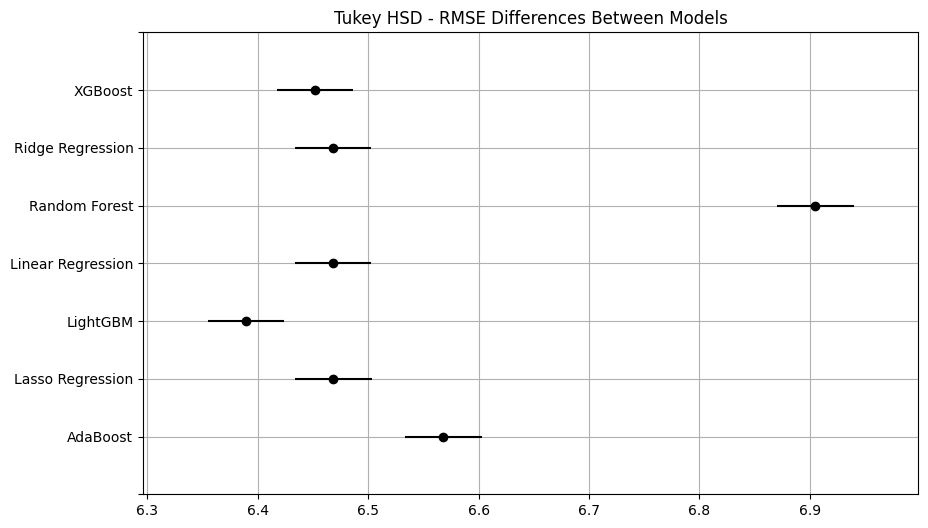

In [16]:
tukey.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD - RMSE Differences Between Models")
plt.grid(True)
plt.show()


In [36]:
%pip install joblib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
from lightgbm import LGBMRegressor

# Retrain LightGBM with the same best settings
final_model = LGBMRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254


LGBMRegressor(random_state=42)

In [13]:
import os
import joblib

# Create the directory if it doesn't exist
os.makedirs('../model', exist_ok=True)

# Now save the model
joblib.dump(final_model, '../model/lightgbm_model.pkl')


['../model/lightgbm_model.pkl']

In [14]:
import joblib

# Assuming you've trained your final model like this:
from lightgbm import LGBMRegressor

final_model = LGBMRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Save the model
joblib.dump(final_model, '../model/lightgbm_model.pkl')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254


['../model/lightgbm_model.pkl']

In [15]:
import os
os.makedirs('model', exist_ok=True)


In [16]:
from sklearn.preprocessing import StandardScaler

# Example: Fit it on training data (if you haven't yet)
scaler = StandardScaler()
scaler.fit(X_train)  # assuming X_train is defined


StandardScaler()

In [17]:
import joblib
joblib.dump(scaler, 'model/scaler.pkl')


['model/scaler.pkl']

In [37]:
%pip install shap lime


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import joblib
import shap
import pandas as pd

# Load model and scaler

model = joblib.load('../model/lightgbm_model.pkl')
scaler = joblib.load('../model/scaler.pkl')



# Load or prepare your input data
X_scaled = scaler.transform(X) if scaler else X


C:\Users\Siri\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
%pip install shap lime joblib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import shap
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import pandas as pd
import joblib

def generate_shap_summary():
    # Load model and data
    model = joblib.load('../model/lightgbm_model.pkl')
    df = pd.read_pickle('../data/final_preprocessed_dataset.pkl')

    # Define features used during training
    scaled_features = ['height_scaled', 'weight_scaled', 'ap_hi_scaled', 'ap_lo_scaled', 
                       'BMI_scaled', 'MAP_scaled', 'Pulse_Pressure_scaled', 'SBP_DBP_Ratio_scaled']
    binary_features = ['gender', 'smoke', 'alco', 'active', 'cardio', 'HighChol_Flag', 'HighGluc_Flag', 'Lifestyle_Risk']
    categorical_encoded = ['Obesity_Class_Encoded']
    
    X = df[scaled_features + binary_features + categorical_encoded]

    # Initialize SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # Global summary plot
    shap.summary_plot(shap_values, X, show=False)
    plt.tight_layout()
    plt.savefig("static/shap_summary.png")
    plt.clf()

    # Global bar plot
    shap.plots.bar(shap_values, show=False)
    plt.tight_layout()
    plt.savefig("static/shap_global_bar.png")
    plt.clf()

    # Local waterfall for the first row
    shap.plots.waterfall(shap_values[0], show=False)
    plt.tight_layout()
    plt.savefig("static/shap_local_waterfall.png")
    plt.clf()

    print("✅ SHAP summary, bar, and local plots saved in 'static/'")



In [32]:
import joblib
import pandas as pd
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Load model and scaler
model = joblib.load('../model/lightgbm_model.pkl')
scaler = joblib.load('../model/scaler.pkl')




# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    mode='regression'
)
explainer = LimeTabularExplainer(training_data=X.values, feature_names=X.columns, mode="regression")
exp = explainer.explain_instance(X.iloc[0].values, model.predict)

# Pick an instance and explain it
instance = X.iloc[0].values
exp = explainer.explain_instance(instance, model.predict)

# Save explanation to HTML
html = exp.as_html()
with open('lime_explanation.html', 'w', encoding='utf-8') as f:
    f.write(html)

print("✅ LIME explanation saved as 'lime_explanation.html'")


C:\Users\Siri\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Siri\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ LIME explanation saved as 'lime_explanation.html'


Difference between Chronological and Biological age 

In [26]:
import joblib
import pandas as pd

model = joblib.load('../model/lightgbm_model.pkl')
scaler = joblib.load('../model/scaler.pkl')
df = pd.read_pickle('../data/final_preprocessed_dataset.pkl')


In [27]:
df['Predicted_Biological_Age'] = final_model.predict(X)


In [28]:
df['Age_Gap'] = df['Predicted_Biological_Age'] - df['Chronological_Age']


In [30]:
df[['Chronological_Age', 'Predicted_Biological_Age', 'Age_Gap']].head()


,Chronological_Age,Predicted_Biological_Age,Age_Gap
0,50,48.587586,-1.412414
1,55,55.904939,0.904939
2,51,54.758543,3.758543
3,48,53.940534,5.940534
4,47,48.395212,1.395212


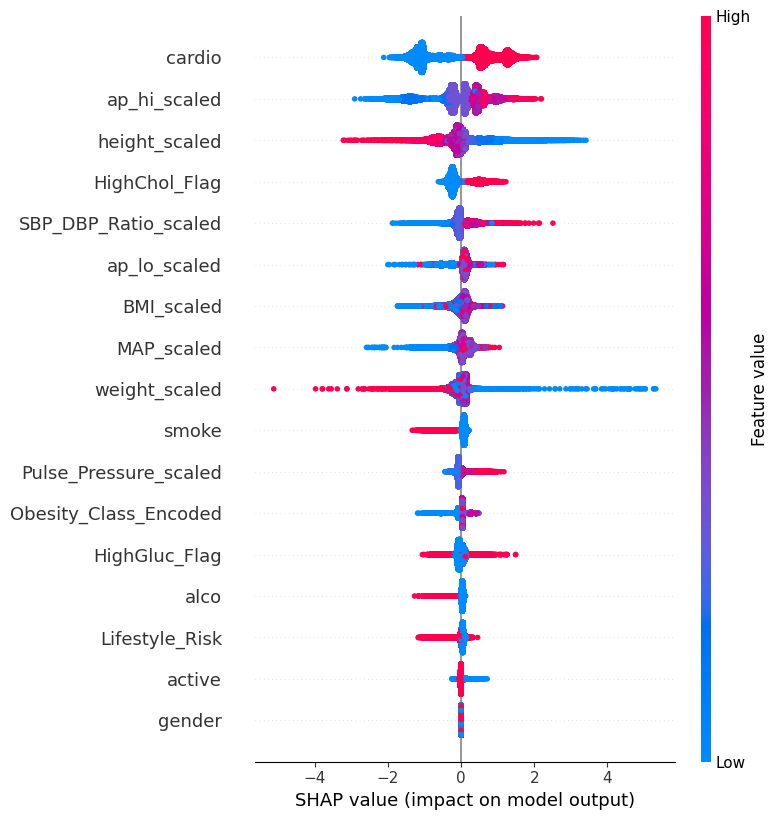

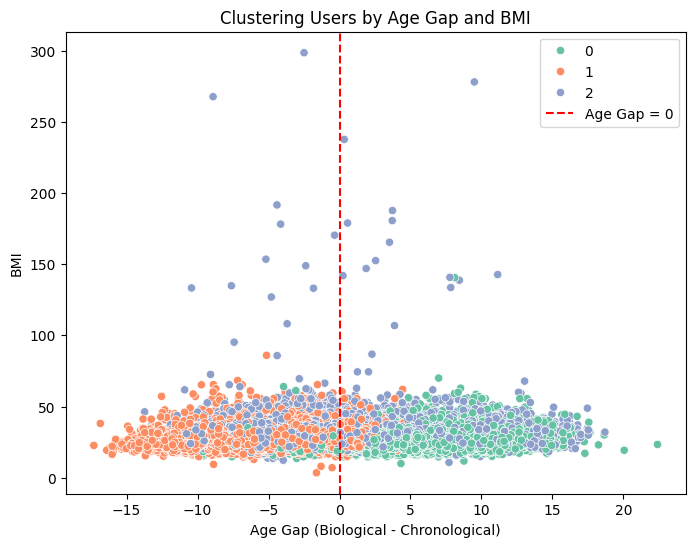

         Age_Gap    BMI     MAP  Lifestyle_Risk
Cluster                                        
0           5.58  26.06   88.31            0.33
1          -4.29  26.96   92.86            0.33
2           0.29  29.88  110.19            0.36


In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for clustering
cluster_features = df[['Age_Gap', 'BMI', 'MAP', 'Lifestyle_Risk']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(cluster_features)

# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Age_Gap', y='BMI', hue='Cluster', palette='Set2')
plt.axvline(0, color='red', linestyle='--', label='Age Gap = 0')
plt.title('Clustering Users by Age Gap and BMI')
plt.xlabel('Age Gap (Biological - Chronological)')
plt.ylabel('BMI')
plt.legend()
plt.show()

# Optional: Cluster interpretation
print(df.groupby('Cluster')[['Age_Gap', 'BMI', 'MAP', 'Lifestyle_Risk']].mean().round(2))


In [39]:
# Final feature list used to train the model
feature_names = scaled_features + binary_features + categorical_encoded


In [46]:
feature_names = [
    'height_scaled', 'weight_scaled', 'ap_hi_scaled', 'ap_lo_scaled',
    'BMI_scaled', 'MAP_scaled', 'Pulse_Pressure_scaled', 'SBP_DBP_Ratio_scaled',
    'gender', 'smoke', 'alco', 'active', 'cardio', 'HighChol_Flag', 'HighGluc_Flag',
    'Lifestyle_Risk', 'Obesity_Class_Encoded'
]


In [47]:
import joblib
joblib.dump(feature_names, '../model/feature_columns.pkl')


['../model/feature_columns.pkl']

In [51]:
feature_names_for_clustering = ['Age_Gap', 'BMI', 'MAP', 'Lifestyle_Risk']


In [52]:
joblib.dump(kmeans, '../model/kmeans_model.pkl')
joblib.dump(feature_names_for_clustering, '../model/cluster_features.pkl')


['../model/cluster_features.pkl']